In [44]:
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs

lfw_people = fetch_lfw_people()
lfw_pairs_train = fetch_lfw_pairs(subset='train')

AJ Cook
AJ Lamas
Aaron Eckhart
Aaron Guiel

lfw_people.images.shape=(13233, 62, 47)
lfw_pairs_train.pairs.shape=(2200, 2, 62, 47)


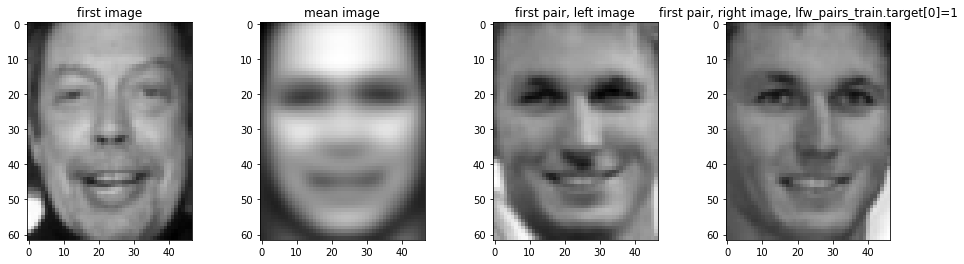

In [45]:
from pylab import *
for name in lfw_people.target_names[0:4]:
    print(name)
print("")
print(f"{lfw_people.images.shape=}")
print(f"{lfw_pairs_train.pairs.shape=}")

figure(figsize=[16,4])
subplot(1,4,1)
title("first image")
A = squeeze(lfw_people.images[0,:,:])
imshow(A, cm.gray)
subplot(1,4,2)
title("mean image")
imshow(mean(lfw_people.images, axis=0), cm.gray)
subplot(1,4,3)
title("first pair, left image")
imshow(lfw_pairs_train.pairs[0,0,:,:], cm.gray)
subplot(1,4,4)
title(f"first pair, right image, {lfw_pairs_train.target[0]=}")
imshow(lfw_pairs_train.pairs[0,1,:,:], cm.gray);

2880


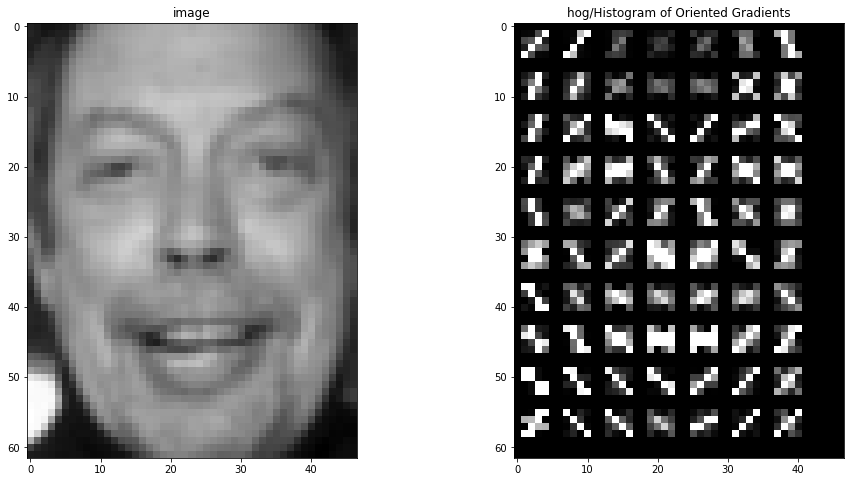

In [55]:
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(A, orientations=8, pixels_per_cell=(6, 6),
                    cells_per_block=(3, 3), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

figure(figsize=[16,8])
subplot(1,2,1)
imshow(A, cm.gray)
title("image")

subplot(1,2,2)
imshow(hog_image_rescaled, cmap=plt.cm.gray)
title('hog/Histogram of Oriented Gradients')

print(len(fd))